## Introduction

Sarcasm detection is a very specialized study subject in NLP, a type of sentiment analysis where the focus is on recognizing sarcasm rather than detecting a sentiment throughout the entire spectrum. As a result, the goal of this field is to determine whether or not a particular text is sarcastic.
    
The first issue we have is that, unlike sentiment analysis, where sentiment categories are clearly defined , the limits of sarcasm are not so well defined. It's also critical to understand what sarcasm is before attempting to detect it.
    
[Cambridge dictionary](https://dictionary.cambridge.org/us/dictionary/english/sarcasm) defines it as: 
>the use of remarks that clearly mean the opposite of what they say, made in order to hurt  someone's feelings or to criticize something in a humorous way.
    
Sarcasm is subjective. Non-native speakers/readers may not get it. So it is a use case for sarcasm detection and was my motive to take up this project.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from plotly import tools,subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from wordcloud import STOPWORDS
import string 
pd.options.mode.chained_assignment = None  # default='warn'

#for NLP
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

**I am going to use a very popular dataset the headlines dataset for this task.**

In [4]:
df =pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# Adding source as a separate column, this we will use to understand the dataset
import re
df['source'] = df['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])
print(df.shape)
df.head()

(26709, 4)


,article_link,headline,is_sarcastic,source
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [6]:
df.isnull().sum() # No null values in this dataset

article_link    0
headline        0
is_sarcastic    0
source          0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
 3   source        26709 non-null  object
dtypes: int64(1), object(3)
memory usage: 834.8+ KB


## Summary Statistics of the Headlines Dataset

0    14985
1    11724
Name: is_sarcastic, dtype: int64 



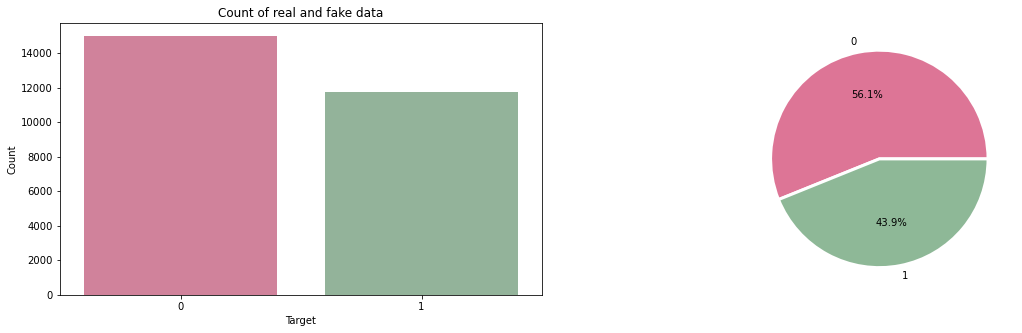

In [8]:
print(df.is_sarcastic.value_counts() ,"\n")
colors = ['#DD7596', '#8EB897']
fig, ax = plt.subplots(1,2, figsize=(19, 5))
f1 = sns.countplot(x=df.is_sarcastic, ax = ax[0], palette=colors);
f1.set_title("Count of real and fake data")
f1.set_ylabel("Count")
f1.set_xlabel("Target")
f2 = plt.pie(df["is_sarcastic"].value_counts().values,explode=[0,0],labels=df.is_sarcastic.value_counts().index, autopct='%1.1f%%',wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },colors=colors)
plt.show()

**Observations:**
- The dataset is fairly balanced but not perfectly balanced so we will need to stratify for target 

In [9]:
print("Null Values: ",df.isnull().sum().sum())
print("\nData Shape: " , df.shape)

Null Values:  0

Data Shape:  (26709, 4)


In [10]:
def find_num_words(data):
    wordlist = []
    splitting_list = data.str.split()
    for i in range(len(splitting_list)):
        for j in range(len(splitting_list[i])):
            wordlist.append(splitting_list[i][j])
            
    wordset = set(wordlist)
    
    print("Number of unique words:",len(wordset),"Number of words:",len(wordlist))

find_num_words(df.headline)

Number of unique words: 36599 Number of words: 262972


In [11]:
262972/36599

7.185223639990164

**On an average a word is expected to be repeated 7 times in the corpus**

### Frequent Occuring word (unclean) in Headlines

In [12]:
#the data is not yet cleaned or preprocessed and we want to see the most frequent words
#overall in the dataset
import plotly.graph_objects as go
from plotly.offline import iplot

all_words = df['headline'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Tealrose',
                         color = all_words.values[2:100]
                        ),
            
    )]

layout = go.Layout(
    title='Frequent Occuring word (unclean) in Headlines'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')


In [13]:
#drop 'article_link' column
df = df.drop('article_link', axis=1)

huffingtonpost    14985
theonion          11724
Name: source, dtype: int64 



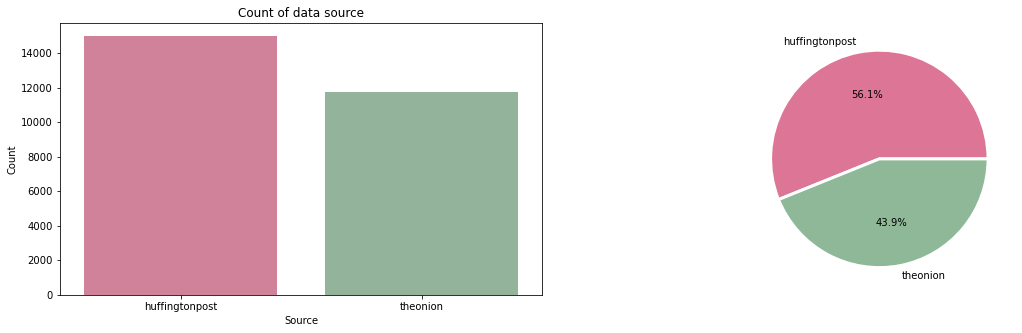

In [14]:
# checking for distribution of the sources of headlines 
print(df.source.value_counts(),'\n')
colors = ['#DD7596', '#8EB897']
fig, ax = plt.subplots(1,2, figsize=(19, 5))
f1 = sns.countplot(x=df.source, ax = ax[0], palette=colors);
f1.set_title("Count of data source")
f1.set_ylabel("Count")
f1.set_xlabel("Source")
f2 = plt.pie(df["source"].value_counts().values,explode=[0,0],labels=df.source.value_counts().index, autopct='%1.1f%%',wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },colors=colors)
plt.show()

**Observations:**
- **theonion is the source around 44% times and 56% huffingtonpost**

In [15]:
df[df.source=='theonion'].is_sarcastic.value_counts(dropna=False)

1    11724
Name: is_sarcastic, dtype: int64

**Observations:**
- **Where the source is theonion, headlines are always sarcastic**

In [16]:
df[df.source=='huffingtonpost'].is_sarcastic.value_counts(dropna=False)

0    14985
Name: is_sarcastic, dtype: int64

**Observations:**
- **Where the source is huffingtonpost, headlines are always not sarcastic**

### Meta Features

I want to create some meta features and then look at how they are distributed between the classes. The ones that will be created are

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Average length of the words

In [17]:
## Number of words in the text 
df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text 
df["num_unique_words"] = df["headline"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text 
df["num_chars"] = df["headline"].apply(lambda x: len(str(x)))

## Number of stopwords in the text 
df["num_stopwords"] = df["headline"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text 
df["num_punctuations"] = df['headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text 
df["mean_word_len"] = df["headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


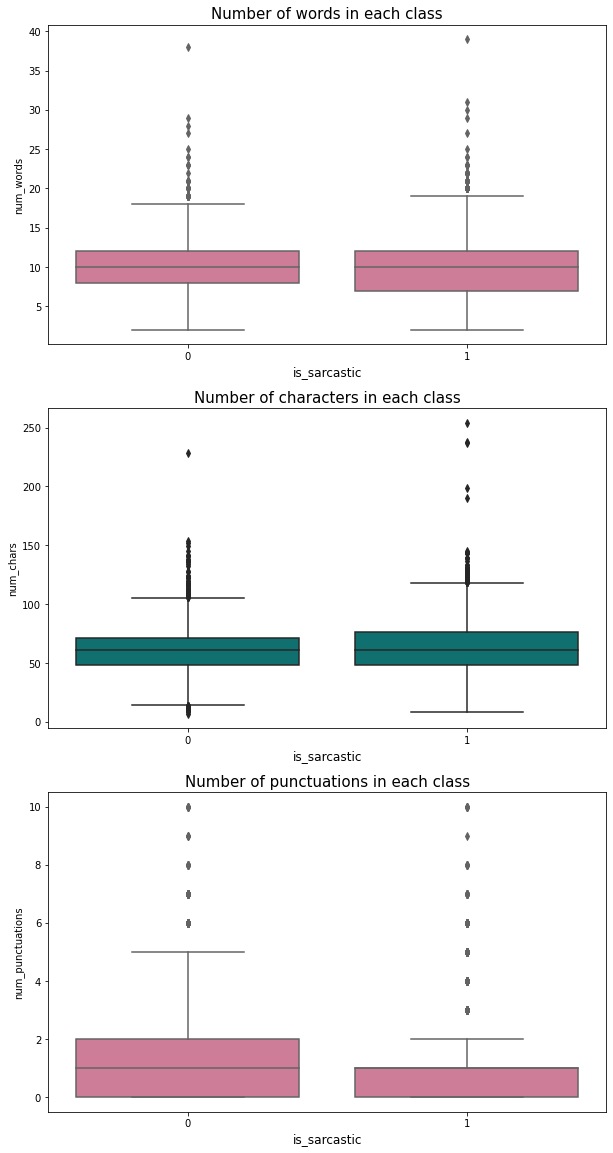

In [18]:
## Truncate some extreme values for better visuals 
df['num_words'].loc[df['num_words']>60] = 60 #truncation for better visuals
df['num_punctuations'].loc[df['num_punctuations']>10] = 10 #truncation for better visuals
df['num_chars'].loc[df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='is_sarcastic', y='num_words', data=df, ax=axes[0],color='palevioletred')
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=df, ax=axes[1],color='teal')
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_punctuations', data=df, ax=axes[2],color='palevioletred')
axes[2].set_xlabel('is_sarcastic', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

 **Observations:**
- Non-sarcastic headlines have more number of punctuations than sarcastic headlines**
- No noticeable difference in other variables
- I expected more punctuations in sarcastic headlines.

**Some research:**
> There are only two punctuation marks that express sarcasm, the exclamation point 
for emphasis and the question mark for questions. 
> Written text lack intonation, facial expressions, so we really need to understand the context rather than the sentiment as words express opposite to what is written in a sarcastic sentence.

**Let's try removing some of the outliers. I will take number of characters in each headline as it shows outliers on both sides high and low both.** 

In [19]:
df = df[(df['num_chars']>15) & (df['num_chars']<105)]

## Graphs after outliers removal

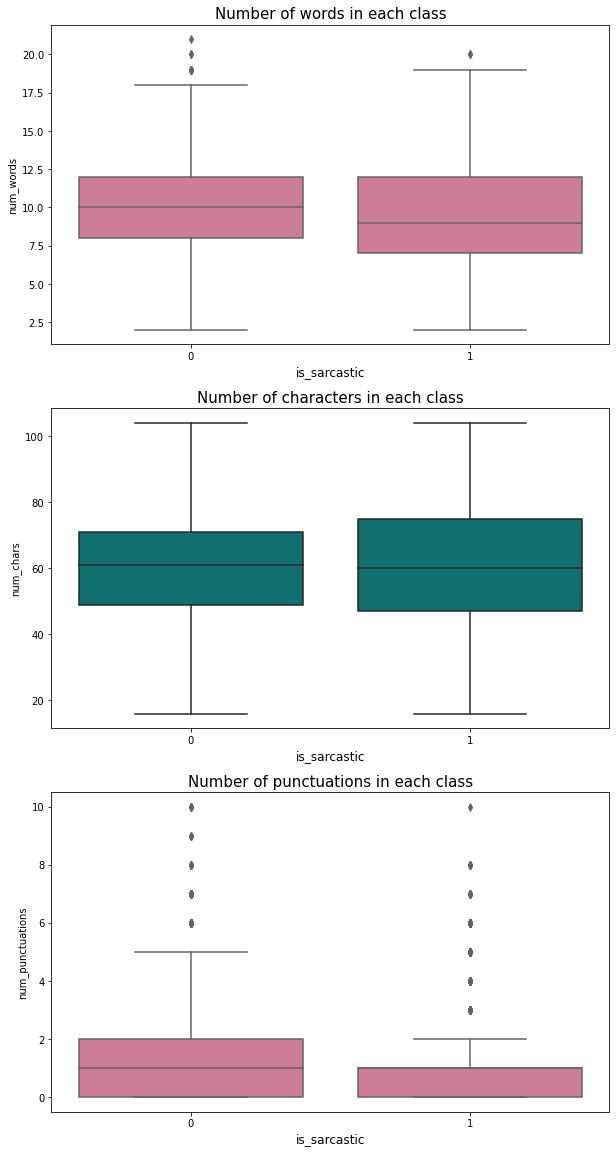

In [20]:
f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='is_sarcastic', y='num_words', data=df, ax=axes[0],color='palevioletred')
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=df, ax=axes[1],color='teal')
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_punctuations', data=df, ax=axes[2],color='palevioletred')
axes[2].set_xlabel('is_sarcastic', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

**As we see this seems to be a better graph with decent number of outliers removed from `num_chars` as also `num_words` columns**

## comparison of num_punctuations in each class of target variable

In [21]:
df[df.is_sarcastic==1].num_punctuations.mean()

0.8778416629809819

In [22]:
df[df.is_sarcastic==0].num_punctuations.mean()

1.288158426512192

**Observations:**
- **Number of punctuations are less in non-sarcastic headlines**

In [23]:
df.head()

,headline,is_sarcastic,source,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,12,78,2,2,5.583333
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,14,84,6,3,5.071429
2,mom starting to fear son's web series closest ...,1,theonion,14,13,79,4,1,4.714286
3,"boehner just wants wife to listen, not come up...",1,theonion,13,13,84,5,2,5.538462
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,11,64,3,2,4.909091


### PREPROCESSING

In [24]:
# Function to remove noise from text and deal with negation
def cleaning_data(comment):
    
    #Remove Non-ASCII characters
    comment = re.sub(r"\xa0",r" ",comment)
    comment = comment.encode("ascii", errors="ignore").decode()
    
    #Lower case the data
    comment = comment.lower()
    
    #Remove HTML Links
    comment = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', comment)   
    comment = re.sub(r'\n','',comment)
    
    #Cleaning the data by removing special characters
    comment = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", comment)
    
     #Handling negations
    comment = re.sub(r"youtu.be", " youtube", comment)
    comment = re.sub(r"https", " http", comment)
    comment = re.sub(r"i'm", " i am", comment)
    comment = re.sub(r"it's", " it is", comment)
    comment = re.sub(r"ain't", "is not",comment)
    comment = re.sub(r"aren't", "are not",comment)
    comment = re.sub(r"couldn't", "could not",comment)
    comment = re.sub(r"didnt", "did not",comment)
    comment = re.sub(r"dont", "do not",comment)
    comment = re.sub(r"doesn't", "does not",comment)
    comment = re.sub(r"hadn't", "had not",comment)
    comment = re.sub(r"hasn't", "has not",comment)
    comment = re.sub(r"haven't", "have not",comment)
    comment = re.sub(r"isn't", "is not",comment)
    comment = re.sub(r"shouldn't", "should not",comment)
    comment = re.sub(r"shan't", "shall not",comment)
    comment = re.sub(r"wasn't", "was not",comment)
    comment = re.sub(r"weren't", "were not",comment)
    comment = re.sub(r"oughtn't", "ought not",comment)
    comment = re.sub(r"that's", " that is", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have", comment)
    comment = re.sub(r"won't", " will not", comment)
    comment = re.sub(r"wouldn't", " would not", comment)
    comment = re.sub(r"don't", " do not", comment)
    comment = re.sub(r"can't", " can not", comment)
    comment = re.sub(r"cannot", " can not", comment)
    comment = re.sub(r"n\'t", " n\'t", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"\'d", " would", comment)
    comment = re.sub(r"\'ll", " will", comment)    
    comment = re.sub(r"!", " ! ", comment)
    comment = re.sub(r"\?", " ? ", comment)
    comment = re.sub(r"\s{2,}", " ", comment)
    
    # Removing all the numbers
    comment = re.sub(r'[0-9]+', ' ', comment)
    
    #Removing all puncs
    comment = re.sub(r'[^\w\s]','',comment)
    
    # Substituting multiple spaces with single space
    comment = re.sub(r'\s+', ' ', comment, flags=re.I)
    
    # Remove single letters
    comment= re.sub(r"\b[a-zA-Z]\b","", comment)
        
    comment = [word for word in comment.split() if len(word) >= 2]
    comment = ' '.join(comment)
    
    return comment
  
#Removing the stop words
def stopwords_data(comment):
    more_stop_words = ["wa", "gt","amp", "u", "ha", "le", "doe", "don",'ve']
    stop_words_ = stop_words.union(more_stop_words)
    comment = [word for word in comment.split() if not word in stop_words_]
    comment = ' '.join(comment)           
    return comment
  
#Tag words by their parts of speech 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Normalising the data by lemmatizing
def lemmatize_data(comment):
    comment = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#Normalise data by user-defined stemming
def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def stemmer(phrase):
    r=[]
    for word in phrase.split():
        r.append(stem(word))
    return ' '.join(r)
  
#Normalising the data by renowned stemming methods

stemmer=SnowballStemmer('english')
def stem_data(comment):
    comment = [stemmer.stem(word) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#list of cleaned words
def cleandata(X_datatrain, X_datatest):
    cleandata_Train = []
    for sen in range(0, len(X_datatrain)): 
        cleandata_Train.append(preprocess_data(str(X_datatrain[sen])))
        
    cleandata_Test = []
    for sen in range(0, len(X_datatest)): 
        cleandata_Test.append(preprocess_data(str(X_datatest[sen])))
    return cleandata_Train, cleandata_Test

In [25]:
#Preprocessing the data
def preprocess_data(review):
    document = cleaning_data(review)
    document = stopwords_data(document)
    document = lemmatize_data(document)
    document = stem_data(document)
    
    return document

In [26]:
print("Cleaning of Training data on process...")
df['headline_processed'] = df['headline'].apply(preprocess_data)
print("Task completed")

Cleaning of Training data on process...
Task completed


> **Preprocessing applied on headline**

In [27]:
df['headline_processed'].head()

0    former versac store clerk sue secret black cod...
1       roseann reviv catch thorni polit mood well bad
2    mom start fear son web seri closest thing gran...
3    boehner want wife listen come altern debt redu...
4             rowl wish snape happi birthday magic way
Name: headline_processed, dtype: object

In [28]:
# to check for data integrity after preprocessing
df['headline_processed'].isnull().sum()

0

### Graphs

#### word length count

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



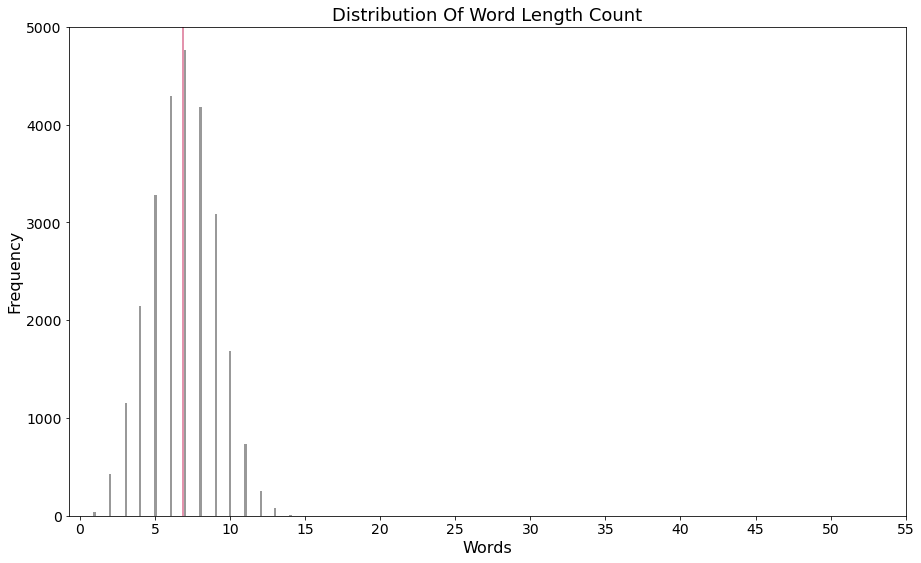

In [29]:
# Generating a list of text lengths

lengths = [len(text.strip().split()) for text in df["headline_processed"]]

# Plotting the text lengths

plt.figure(figsize = (15,9), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "palevioletred")
plt.title("Distribution Of Word Length Count", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,60,5), size = 14)
plt.yticks(size = 14)
plt.savefig('Distribution_Word_length_Count.png')
plt.show()

# The reddish line marks the mean length


**Observations:**
- Average word count is around 7. this we have seen earlier too

## Wordclouds

There are 1122892 words in the combination of all review.


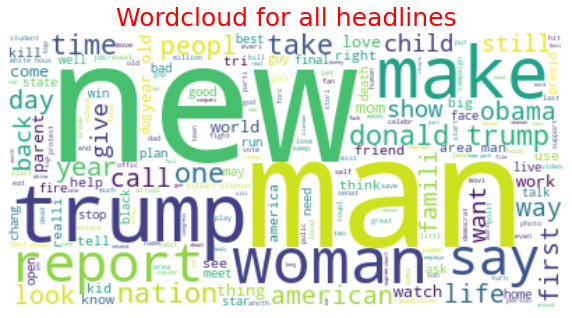

In [38]:
from wordcloud import WordCloud
text = " ".join(review for review in df.headline_processed)
print ("There are {} words in the combination of all review.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title("Wordcloud for all headlines", fontsize=25, color='red')
plt.show()

In [31]:
# making separate df for two classes for analysis
df_1 = df[df["is_sarcastic"]==1]
df_0 = df[df["is_sarcastic"]==0]

There are 616013 words in the combination of all review.


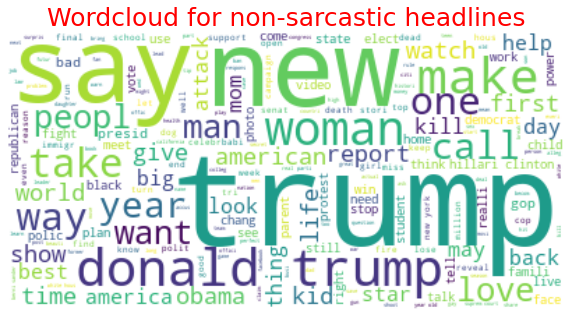

In [36]:
#non-sarcastic headlines
text = " ".join(review for review in df_0.headline_processed)
print ("There are {} words in the combination of all review.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title("Wordcloud for non-sarcastic headlines", fontsize=25, color='red')
plt.show()

There are 506878 words in the combination of all review.


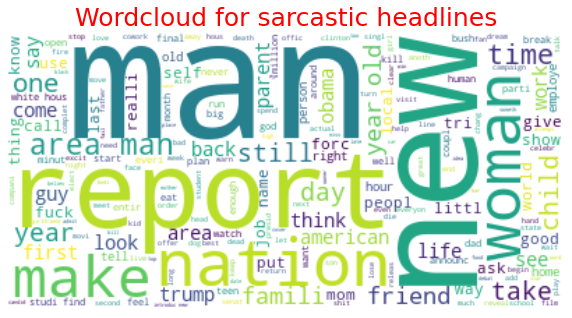

In [37]:
#sarcastic headlines
text = " ".join(review for review in df_1.headline_processed)
print ("There are {} words in the combination of all review.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.title("Wordcloud for sarcastic headlines", fontsize=25, color='red')
plt.show()

In [123]:
# how my df looks after processing headlines
df.head()

,headline,is_sarcastic,source,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len,headline_processed
0,former versace store clerk sues over secret 'b...,0,huffingtonpost,12,12,78,2,2,5.583333,former versac store clerk sue secret black cod...
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost,14,14,84,6,3,5.071429,roseann reviv catch thorni polit mood well bad
2,mom starting to fear son's web series closest ...,1,theonion,14,13,79,4,1,4.714286,mom start fear son web seri closest thing gran...
3,"boehner just wants wife to listen, not come up...",1,theonion,13,13,84,5,2,5.538462,boehner want wife listen come altern debt redu...
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost,11,11,64,3,2,4.909091,rowl wish snape happi birthday magic way


### Frequent Occuring word (clean) in Headlines

In [39]:
all_words = df['headline_processed'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Tealrose',
                         color = all_words.values[2:100]
                        ),
            
    )]

layout = go.Layout(
    title='Frequent Occuring word (clean) in Headlines'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')


### Word Frequency plot of sarcastic & non-sarcasting headlines

In [40]:
from collections import defaultdict

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from non-sarcastic class ##
freq_dict = defaultdict(int)
for sent in df_0["headline_processed"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'teal')

## Get the bar chart from sarcastic class ##
freq_dict = defaultdict(int)
for sent in df_1["headline_processed"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'palevioletred')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-sarcastic headlines", 
                                          "Frequent words of sarcastic headlines"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

### bigram frequency plots of the two classes

In [41]:
freq_dict = defaultdict(int)
for sent in df_0["headline_processed"]:
    for word in generate_ngrams(sent,n_gram=2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'teal')


freq_dict = defaultdict(int)
for sent in df_1["headline_processed"]:
    for word in generate_ngrams(sent,n_gram=2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'palevioletred')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of non-sarcastic headlines", 
                                          "Frequent bigrams of sarcastic headlines"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

### trigram frequency plots of the two classes

In [43]:
freq_dict = defaultdict(int)
for sent in df_0["headline_processed"]:
    for word in generate_ngrams(sent,n_gram=3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'teal')


freq_dict = defaultdict(int)
for sent in df_1["headline_processed"]:
    for word in generate_ngrams(sent,n_gram=3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'palevioletred')

# Creating two subplots
fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of non-sarcastic headlines", 
                                          "Frequent trigrams of sarcastic headlines"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

**Observations:**
- **I would like to incorporate bigrams and trigrams in my classical ML modeling to understand the context more**

In [44]:
# to check again for any inconsistencies
df.describe()

,is_sarcastic,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
count,26151.000000,26151.000000,26151.000000,26151.000000,26151.000000,26151.000000,26151.000000
mean,0.432297,9.744484,9.616955,60.209782,2.728576,1.110780,5.382913
std,0.495405,2.955260,2.879505,17.599015,1.776708,1.289316,0.985581
min,0.000000,2.000000,2.000000,16.000000,0.000000,0.000000,2.333333
25%,0.000000,8.000000,8.000000,48.000000,1.000000,0.000000,4.714286
50%,0.000000,10.000000,10.000000,61.000000,2.000000,1.000000,5.285714
75%,1.000000,12.000000,12.000000,72.000000,4.000000,2.000000,6.000000
max,1.000000,21.000000,19.000000,104.000000,12.000000,10.000000,13.333333


In [46]:
#saving the file to `Preprocessed_Headlines.csv`
df.to_csv('Preprocessed_Headlines.csv',index=False)

**References**:

1. https://medianism.org/2015/01/08/sarcasm-marks-we-dont-do-no-stinking-sarcasm/m